**Architecture **

<img src="http://drive.google.com/uc?export=view&id=12JomC2IswVbNGdE0IIvPpUk8vPjP-MBQ"  alt="artchtecture">


---



(1) Importing dependency

In [1]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import os

import numpy as np
np.random.seed(13)
import random
random.seed(13)

import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


(2) Get Data

In [2]:
base_dir = '/data/private/SU/bbchip13/chainsaw_classification/data/'
train_dir = base_dir+'train/'
val_dir = base_dir+'val/'
test_dir = base_dir+'test/'

In [3]:
def load_wavs(filenames):
    return np.asarray([librosa.load(filename)[0] for filename in tqdm(filenames)])

### If you have lack of memory, Use this
#     wav = librosa.load(filenames[0])
#     wavs = np.zeros( (len(filenames), wav.shape[0]) )
#     for i, filename in enumerate(filenames):
#         wavs[i][:] = librosa.load(filename)[:]
#     return wavs
    
def find_y_by_filename(filename, y_dict):
    basename = os.path.basename(filename)
    y = y_dict[basename]
    return y

def make_y_by_filenames(filenames, y_dict):
    return np.asarray([find_y_by_filename(filename, y_dict) 
                           for filename in filenames])

def make_xy_data(filenames, y_dict):
    x_train = load_wavs(filenames)
    x_train = np.reshape(x_train, (*x_train.shape, 1))
    y_train = make_y_by_filenames(filenames, y_dict)
    return x_train, y_train

In [4]:
### Make Y data
annotations_filename = 'data_annotations.csv'
df = pd.read_csv(annotations_filename)
y_dict = {filename:int(label) for _, filename, label, _ in df.itertuples()}
# y_dict

In [5]:
print('Make train data.......')
x_train_wav_filenames = [train_dir+filename for filename in os.listdir(train_dir)
                            if filename.endswith('.wav')]#[:10]
x_train, y_train = make_xy_data(x_train_wav_filenames, y_dict)

print('Make validation data.......')
x_val_wav_filenames = [val_dir+filename for filename in os.listdir(val_dir)
                            if filename.endswith('.wav')]#[:2]
x_val, y_val = make_xy_data(x_val_wav_filenames, y_dict)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

Make train data.......



Make validation data.......



(1543, 110250, 1) (1543,) (714, 110250, 1) (714,)


(3) Create a sequential model

In [6]:
model=Sequential()

# Layer 1
model.add(Conv1D (kernel_size=3, filters=128, strides=3, padding='valid',
                  kernel_initializer='he_uniform', input_shape=x_train.shape[1:]))                  
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 2
model.add(Conv1D (kernel_size=3, filters=128, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 3
model.add(Conv1D (kernel_size=3, filters=128, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 4
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 5
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 6
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 7
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 8
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 9
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 10
model.add(Conv1D (kernel_size=3, filters=512, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 11
model.add(Dropout(0.5))
model.add(Flatten())

# Layer 12
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 36750, 128)        512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 36750, 128)        512       
_________________________________________________________________
activation_1 (Activation)    (None, 36750, 128)        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36750, 128)        49280     
_________________________________________________________________
batch_normalization_2 (Batch (None, 36750, 128)        512       
_________________________________________________________________
activation_2 (Activation)    (None, 36750, 128)        0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12250, 128)        0         
__________

(4) Compile 

In [7]:
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
              metrics=['accuracy'])

(5) Train

In [8]:
model_path = 'SampleCNN_check_point/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [9]:
hist = model.fit(x_train, y_train, batch_size=64, epochs=10000, validation_data=[x_val, y_val], 
                 shuffle=True, callbacks = [checkpointer, early_stopping])

Train on 1543 samples, validate on 714 samples
Epoch 1/10000
1543/1543 [==============================] - 33s 22ms/step - loss: 0.3428 - acc: 0.8691 - val_loss: 0.2838 - val_acc: 0.9146

Epoch 00001: val_loss improved from inf to 0.28384, saving model to SampleCNN_check_point/01-0.2838.hdf5
Epoch 2/10000
1543/1543 [==============================] - 27s 18ms/step - loss: 0.1758 - acc: 0.9417 - val_loss: 0.6050 - val_acc: 0.8151

Epoch 00002: val_loss did not improve from 0.28384
Epoch 3/10000
1543/1543 [==============================] - 27s 18ms/step - loss: 0.1505 - acc: 0.9475 - val_loss: 0.1771 - val_acc: 0.9314

Epoch 00003: val_loss improved from 0.28384 to 0.17711, saving model to SampleCNN_check_point/03-0.1771.hdf5
Epoch 4/10000
1543/1543 [==============================] - 27s 18ms/step - loss: 0.1221 - acc: 0.9514 - val_loss: 0.1434 - val_acc: 0.9552

Epoch 00004: val_loss improved from 0.17711 to 0.14339, saving model to SampleCNN_check_point/04-0.1434.hdf5
Epoch 5/10000
1543/

1543/1543 [==============================] - 27s 17ms/step - loss: 0.0529 - acc: 0.9857 - val_loss: 0.1902 - val_acc: 0.9650

Epoch 00082: val_loss did not improve from 0.07202
Epoch 83/10000
1543/1543 [==============================] - 27s 18ms/step - loss: 0.0254 - acc: 0.9916 - val_loss: 0.1172 - val_acc: 0.9706

Epoch 00083: val_loss did not improve from 0.07202
Epoch 84/10000
1543/1543 [==============================] - 27s 18ms/step - loss: 0.0213 - acc: 0.9922 - val_loss: 0.1204 - val_acc: 0.9720

Epoch 00084: val_loss did not improve from 0.07202
Epoch 85/10000
1543/1543 [==============================] - 27s 18ms/step - loss: 0.0158 - acc: 0.9948 - val_loss: 0.0714 - val_acc: 0.9804

Epoch 00085: val_loss improved from 0.07202 to 0.07137, saving model to SampleCNN_check_point/85-0.0714.hdf5
Epoch 86/10000
1543/1543 [==============================] - 27s 17ms/step - loss: 0.0142 - acc: 0.9935 - val_loss: 0.0808 - val_acc: 0.9790

Epoch 00086: val_loss did not improve from 0.071


Epoch 00166: val_loss did not improve from 0.07137
Epoch 167/10000
1543/1543 [==============================] - 27s 17ms/step - loss: 0.0147 - acc: 0.9961 - val_loss: 0.1243 - val_acc: 0.9636

Epoch 00167: val_loss did not improve from 0.07137
Epoch 168/10000
1543/1543 [==============================] - 27s 18ms/step - loss: 0.0148 - acc: 0.9942 - val_loss: 0.0984 - val_acc: 0.9650

Epoch 00168: val_loss did not improve from 0.07137
Epoch 169/10000
1543/1543 [==============================] - 27s 18ms/step - loss: 0.0121 - acc: 0.9948 - val_loss: 0.1298 - val_acc: 0.9678

Epoch 00169: val_loss did not improve from 0.07137
Epoch 170/10000
1543/1543 [==============================] - 27s 18ms/step - loss: 0.0352 - acc: 0.9877 - val_loss: 0.1171 - val_acc: 0.9678

Epoch 00170: val_loss did not improve from 0.07137
Epoch 171/10000
1543/1543 [==============================] - 27s 17ms/step - loss: 0.0607 - acc: 0.9773 - val_loss: 0.1869 - val_acc: 0.9650

Epoch 00171: val_loss did not impr

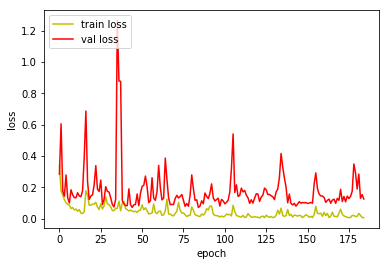

In [10]:
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

(6) Test

In [11]:
print('Make test data.......')
x_test_wav_filenames = [test_dir+filename for filename in os.listdir(test_dir)
                            if filename.endswith('.wav')]#[:2]
x_test, y_test = make_xy_data(x_test_wav_filenames, y_dict)

Make test data.......


In [13]:
model = load_model(model_path+'85-0.0714.hdf5')

In [14]:
[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)

1054/1054 [==============================] - 7s 7ms/step
Loss: 0.0547122646731093 Accuracy: 0.9829222011385199


In [15]:
pred = model.predict(x_test)
test_f1_score = f1_score(y_test, pred > 0.5)
print('F1 Score:', test_f1_score)

F1 Score: 0.9858044164037855


In [16]:
%timeit -n 5 -r 5 model.predict(x_test)

5.94 s ± 9.97 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
